# Control in a continuous action space with DDPG
_Authors:_ Aristotelis Dimitriou, Konstantinos Spinakis

---

### Introduction

In this reinforcement learning project, we implement the Deep Deterministic Policy Gradient (DDPG) algorithm to handle continuous action spaces while maintaining the benefits of Deep Q-learning (DQN). The objective is to stabilize an inverted pendulum in the Pendulum-v1 environment from OpenAI Gym.

DDPG is an actor-critic algorithm that utilizes one neural network (critic) to estimate the Q function and another (actor) to select the action. It is based on the deterministic policy gradient theorem, allowing both the actor and critic to be trained off-policy from a replay buffer. The policy network outputs a specific action instead of a probability distribution, enabling a flexible exploration strategy.

* The `Pendulum-v1` environment provides a three-dimensional observation vector $(\cos(\alpha), \sin(\alpha), \dot{\alpha})$ where $\alpha$ represents the angle between the pendulum and the vertical line. 

* The action is a scalar value between -2 and 2, representing the torque applied to the pendulum's unique joint. 

* The control policy must learn to swing the pendulum to gain momentum before stabilizing it in a vertical position with minimal torque. 

* The reward function is defined as $-(\alpha^2 + 0.1\cdot\dot{\alpha}^2 + 0.001\cdot\tau^2)$, with the maximum reward of 0 achieved when the pendulum is vertically positioned, motionless, and with no torque applied.


In [249]:
import gym
import numpy as np
from helpers import NormalizedEnv, RandomAgent
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output


___
### Heuristic Policy

In this section, we will familiarize ourselves with the `Pendulum-v1` environment by implementing a simple heuristic policy to attempt stabilizing the pendulum. We will compare the heuristic policy with a random policy to verify the increase in average reward.

_**Tasks:**_


1. Create an instance of the `Pendulum-v1` environment and wrap it in a `NormalizedEnv` class.

In [250]:
env = NormalizedEnv(gym.make('Pendulum-v1'))

2. Implement a functions that simulates an interaction between the environment and the agent. Returning the average cumulative reward.

In [251]:
def run_agent(agent, env, episodes=10, verbose=False):
    rewards = []
    for i in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.compute_action(state)
            next_state, reward, _, done, _ = env.step(action)
            total_reward += reward
            state = next_state
            if verbose:
                print(f'Episode {i+1}/{episodes}')
                print(f'State: {state}')
                print(f'Action: {action}')
                print(f'Reward: {reward}')
                print(f'Done: {done}')
                print('------------------')
        rewards.append(total_reward)
    return np.mean(rewards)

3. Implement a heuristic policy for the pendulum (`HeuristicPendulumAgent`).

In [252]:
class HeuristicPendulumAgent:
    def __init__(self, env, fixed_torque=0.5, verbose=False):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.fixed_torque = fixed_torque
        self.verbose = verbose

    def compute_action(self, state):
        if self.verbose:
            print(f'State_HA: {state}')
        x, y, angular_velocity = state
        if self.verbose:
            print(f'x: {x}, y: {y}, angular_velocity: {angular_velocity}')
        if y < 0:   # Lower half of the domain
            action = np.sign(angular_velocity) * self.fixed_torque
        else:       # Upper half of the domain
            action = -np.sign(angular_velocity) * self.fixed_torque
        return np.array([action])


5. Compare the average cumulative reward obtained by the heuristic policy and compare it with the reward of the random agent.

In [253]:
heuristic_agent = HeuristicPendulumAgent(env, verbose=False)
random_agent = RandomAgent(env)

heuristic_agent_avg_reward = run_agent(heuristic_agent, env, verbose=False)
random_agent_avg_reward = run_agent(random_agent, env, verbose=False)
print(f'Random agent average reward: {random_agent_avg_reward:.2f}')
print(f'Heuristic agent average reward: {heuristic_agent_avg_reward:.2f}')

Random agent average reward: -1283.06
Heuristic agent average reward: -1276.03


In [254]:
class ReplayBuffer:
    """ A buffer for storing transitions sampled from the environment. """
    def __init__(self, max_size, verbose=False):
        self.max_size = max_size
        self.transitions = []
        self.verbose = verbose
        
    def store(self, transition):
        """ Store a transition. """
        if self.verbose:
            print(f'Storing transition {transition}')
            
        if len(self.transitions) < self.max_size:
            self.transitions.append(transition)
        else:
            self.transitions.pop(0)
            self.transitions.append(transition)
        
    def sample(self, batch_size):
        """ Sample a batch of transitions. """
        batch = []
        for _ in range(batch_size):
            idx = np.random.randint(0, len(self.transitions))
            batch.append(self.transitions[idx])
            if self.verbose:
                print(f'Sampling transition {self.transitions[idx]}')
        return batch
    
    def __len__(self):
        return len(self.transitions)
    
        

In [255]:
class QNetwork(torch.nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        """ Forward pass of the network. """
        x = x.view(-1, 4)   # -1 means infer this dimension
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x
        

In [256]:
def train_q_network(q_network, transitions, optimizer, gamma, verbose=False):
    """
    Train Q-Network using 1-step TD-learning rule.

    Parameters:
    q_network (QNetwork): The Q-Network instance to be trained.
    transitions (list): A list of tuples containing the transitions used for training.
                        Each tuple should have the format (state, action, reward, next_state, trunc).
    optimizer (torch.optim.Optimizer): The optimizer used for updating the Q-Network's weights.
    gamma (float): The discount factor for future rewards (0 <= gamma <= 1).

    Returns:
    loss (float): The loss value after training the Q-Network with the given batch of transitions.
    """

    # Unpack transitions
    states, actions, rewards, next_states, next_actions, trunc = zip(*transitions)

    # Convert lists to PyTorch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.float32).unsqueeze(1).squeeze(2)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    next_actions = torch.tensor(next_actions, dtype=torch.float32).unsqueeze(1).squeeze(2)
    trunc = torch.tensor(trunc, dtype=torch.float32).unsqueeze(1)

    # Concatenate states and actions to form input to Q-network
    state_action_pairs = torch.cat([states, actions], dim=1)
    next_state_action_pairs = torch.cat([next_states, next_actions], dim=1)

    # Computes Q-values for the given state-action pairs
    q_values = q_network(state_action_pairs)

    # Compute target Q-values
    with torch.no_grad():
        q_targets = rewards + gamma * q_network(next_state_action_pairs) * (1 - trunc)

    # Compute loss
    #   Use MSE
    loss = torch.nn.functional.mse_loss(q_values, q_targets)

    # Perform backpropagation
    optimizer.zero_grad()   # Reset gradients to zero
    loss.backward()         # Compute gradients
    optimizer.step()        # Update weights

    if verbose:
        print(f'States:\n{states}')
        print(f'Actions:\n{actions}')
        print(f'Rewards:\n{rewards}')
        print(f'Next states:\n{next_states}')
        print(f'Trunc:\n{trunc}')
        print(f'State-action pair:\n{state_action_pairs}')
        print(f'Next state-action pair:\n{next_state_action_pairs}')
        print(f'Q-values:\n{q_values}')
        print(f'Target Q-values:\n{q_targets}')
        print(f'Loss: {loss.item()}')

    return loss.item()



In [257]:

# # Make variables to be given to the train_q_network function
q_network = QNetwork()
optimizer = torch.optim.Adam(q_network.parameters(), lr=0.001)
gamma = 0.99

# Make a replay buffer
replay_buffer = ReplayBuffer(max_size=1000, verbose=False)

# Make a heuristic agent
heuristic_agent = HeuristicPendulumAgent(env, verbose=False)

# Collect some transitions
transitions = []
for _ in range(3):
    state, _,  = env.reset()
    action = heuristic_agent.compute_action(state)
    next_state, reward, _, done, _ = env.step(action)
    next_action = heuristic_agent.compute_action(next_state)
    transition = (state, action, reward, next_state, next_action, done)
    transitions.append(transition)
    replay_buffer.store(transition)


train_q_network(q_network, transitions, optimizer, gamma, verbose=False)

14.84338665008545

In [258]:
def create_heatmap(q_network, action_range, velocity_range, n_points):
    heatmap = np.zeros((n_points, n_points))

    for i, action in enumerate(np.linspace(action_range[0], action_range[1], n_points)):
        for j, velocity in enumerate(np.linspace(velocity_range[0], velocity_range[1], n_points)):
            inputs = []
            for angle in np.linspace(-np.pi, np.pi, n_points):
                state = [np.cos(angle), np.sin(angle), velocity]
                inputs.append(np.hstack((state, action)))
            inputs = torch.tensor(inputs, dtype=torch.float32)
            q_values = q_network(inputs).detach().numpy()
            heatmap[j, :] = q_values.flatten()

    return heatmap

def plot_heatmap(heatmap, action_range, velocity_range):
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap, cmap='viridis', origin='lower',
               extent=[-np.pi, np.pi, velocity_range[0], velocity_range[1]],
               aspect='auto')
    plt.colorbar()
    plt.xlabel('Angular Position (radians)')
    plt.ylabel('Angular Velocity (rad/s)')
    plt.title('Q-function heatmap')
    plt.show()


Episode 1000/1000


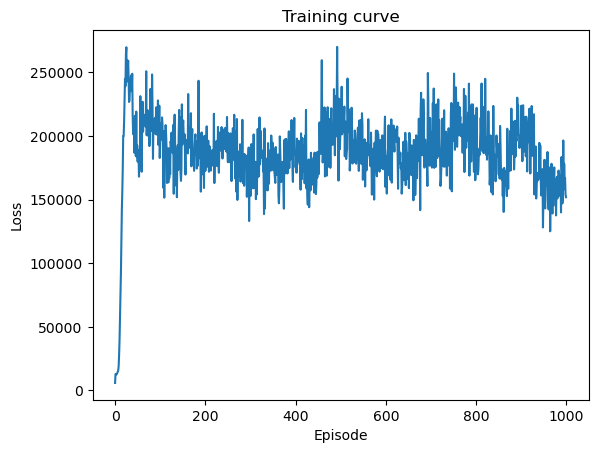

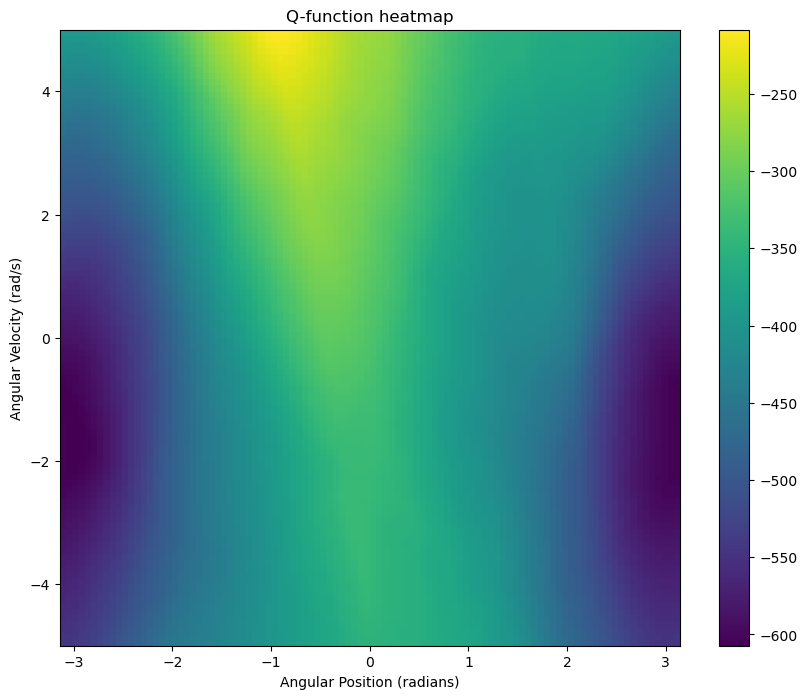

In [259]:
# Assuming all necessary classes and functions are already defined above.

# Hyperparameters
buffer_size = 10000
batch_size = 128
gamma = 0.99
lr = 1e-4
episodes = 1000

# Initialize environment, agents, and replay buffer
env = NormalizedEnv(gym.make('Pendulum-v1'))
heuristic_agent = HeuristicPendulumAgent(env)
replay_buffer = ReplayBuffer(buffer_size)

# Create Q-network and optimizer
q_network = QNetwork()
optimizer = torch.optim.Adam(q_network.parameters(), lr=lr)

# Training loop
episode_losses = []
for episode in range(episodes):
    clear_output(wait=True)
    print(f'Episode {episode + 1}/{episodes}')
    state, _ = env.reset()
    done = False
    total_loss = 0

    while not done:
        action = heuristic_agent.compute_action(state)
        next_state, reward, _, done, _ = env.step(action)
        next_action = heuristic_agent.compute_action(next_state)

        # Truncated due to env constraints (True) or terminal state (False)
        # trunc = done and not env.unwrapped._past_limit()

        transition = (state, action, reward, next_state, next_action, done)
        replay_buffer.store(transition)

        if len(replay_buffer) > batch_size:
            transitions = replay_buffer.sample(batch_size)
            loss = train_q_network(q_network, transitions, optimizer, gamma)
            total_loss += loss

        state = next_state

    episode_losses.append(total_loss)

# Plot training curve
plt.plot(episode_losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training curve')
plt.show()

# Create and plot heatmap
action_range = [-2, 2]
velocity_range = [-5, 5]
n_points = 100

heatmap = create_heatmap(q_network, action_range, velocity_range, n_points)
plot_heatmap(heatmap, action_range, velocity_range)
